In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
from scipy.linalg import eigh

In [3]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
many_blobs = datasets.make_blobs(n_samples=n_samples, n_features=5, centers = 5, random_state = 9)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

In [4]:
data_list = [noisy_circles[0], noisy_moons[0], blobs[0], no_structure[0], aniso[0], varied[0], many_blobs[0]]

In [5]:
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform

def similarity_func(u, v):
    dist = euclidean(u,v)
    return 1/(1 + dist)
def similarity_matrix(data, threshold = 0.65):
    n = data.shape[0]
    dists = pdist(data, similarity_func)
    DF_euclid = squareform(dists)
    ## to make the matrix sparse
    DF_euclid[DF_euclid < threshold] = 0 
    return DF_euclid

In [6]:
# start = time.time()
# a = similarity_matrix(data_list[0])
# end = time.time()
# end-start

In [7]:
# np.any(a.sum(axis = 0) <= 1e-15)

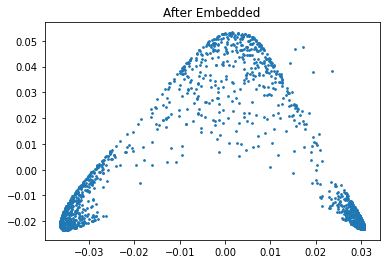

In [36]:
data = data_list[5]
data = StandardScaler().fit_transform(data)
W = similarity_matrix(data, 0.2)
D = np.diag(W.sum(axis = 0)) ##Degree Matrix
DW = W.sum(axis = 0)
D_21 = np.diag(DW**(-1/2)) ##D^(-1/2)
L = D-W
normal_L = D_21@L@D_21 ##Normalized Graph Laplacian
el, ev = eigh(normal_L, subset_by_index = [0, 2])
fiedler_vector = ev[:, 1:]
plt.title('After Embedded')
plt.scatter(fiedler_vector[:, 0],fiedler_vector[:, 1], s= 3)

# plt.scatter(data[:, 0], data[:, 1])
plt.savefig('after.png')
# plt.legend()

In [21]:
fiedler_vector.shape

(1500, 2)

In [ ]:
data_list[2]

In [ ]:
# We need to find k-1 fiedler vectors if we want k clusters 
el, ev = eigh(M, subset_by_index = [0, n_clusters-1])
fiedler_vector = ev[:, 1:]
# The fiedler vector embedds the original data points to a smaller space. 
# We use kmeans method to cluster to embedded points, and return the labels.
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)
kmeans.fit(fiedler_vector)

In [8]:
def spectral_clustering(data, n_clusters = 2, normalized = True, modularity = False, s_threshold = 0.65, sim = None):
    data = StandardScaler().fit_transform(data)
    n = data.shape[0]
    if sim is None:
        W = similarity_matrix(data, s_threshold)
    else:
        W = sim
    D = np.diag(W.sum(axis = 0))
    DW = W.sum(axis = 0)
    DW[DW <= 1e-10] = 1e-10
    print(normalized)
    L = D - W
    if modularity:
        DD = (DW.reshape(n, 1) @ DW.reshape(1, n))/(W.sum())
        M = W - DD
        el, ev = eigh(M, subset_by_index = [0, n_clusters-1])
    elif normalized:
        D_21 = np.diag(DW**(-1/2))
        normal_L = D_21@L@D_21
        el, ev = eigh(normal_L, subset_by_index = [0, n_clusters-1])
    else:
        el, ev = eigh(L, subset_by_index = [0, n_clusters-1])
    fiedler_vector = ev[:, 1:]
    kmeans = KMeans(n_clusters=n_clusters, random_state = 0)
    kmeans.fit(fiedler_vector)
    return kmeans.labels_

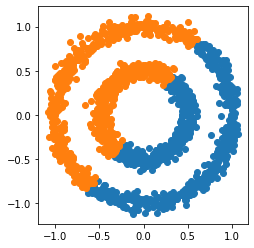

In [11]:
def kmeans_clustering(data, n_clusters = 2):    
    kmeans = KMeans(n_clusters=n_clusters, random_state = 0)
    kmeans.fit(data)
    return kmeans.labels_
data = data_list[0]
label = kmeans_clustering(data, n_clusters=2)
ax = plt.gca()
ax.set_aspect("equal")
labels = np.unique(label)
for l in labels:
    plt.scatter(data[label == l][:, 0], data[label == l][:, 1])

In [ ]:
data = data_list[1]
label = spectral_clustering(data, n_clusters=2, s_threshold = 0.6)
ax = plt.gca()
ax.set_aspect("equal")
labels = np.unique(label)
for l in labels:
    plt.scatter(data[label == l][:, 0], data[label == l][:, 1])

In [12]:
def plot_result(which, data, n_clusters, threshold):
    data = StandardScaler().fit_transform(data)
    sim = similarity_matrix(data, threshold)
    plt.subplot(which)
    if which%10 == 1:
        plt.title("Spectral_Clustering \nwith Normalized Laplacian", fontsize = 9)
    ax = plt.gca()
    ax.set_aspect("equal")
    label = spectral_clustering(data, n_clusters=n_clusters, s_threshold = threshold, sim = sim)
    labels = np.unique(label)
    for l in labels:
        plt.scatter(data[label == l][:, 0], data[label == l][:, 1], s=3)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(which+1)
    if which%10 == 1:
        plt.title("Spectral_Clustering \nwith Unnormalized Laplacian", fontsize = 9)
    ax = plt.gca()
    ax.set_aspect("equal")
    label = spectral_clustering(data, n_clusters=n_clusters,normalized = False, s_threshold = threshold, sim = sim)
    labels = np.unique(label)
    for l in labels:
        plt.scatter(data[label == l][:, 0], data[label == l][:, 1], s=3)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(which+2)
    if which%10 == 1:
        plt.title("Kmeans", fontsize = 12)
    ax = plt.gca()
    ax.set_aspect("equal")
    label = kmeans_clustering(data, n_clusters=n_clusters)
    labels = np.unique(label)
    for l in labels:
        plt.scatter(data[label == l][:, 0], data[label == l][:, 1], s=3)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())

True
False
True
False
True
False


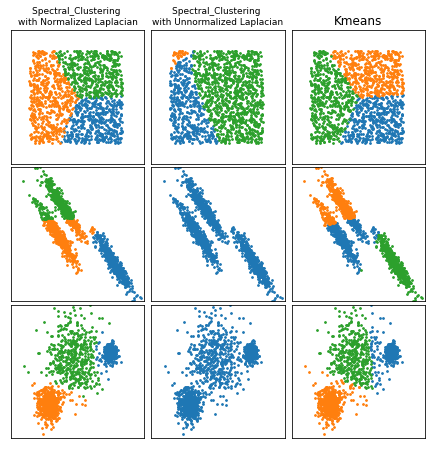

In [14]:
plt.figure(figsize=(6, 6))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_result(331, data = data_list[3], n_clusters=3, threshold=0.2)
plot_result(334, data = data_list[4], n_clusters=3, threshold=0.2)
plot_result(337, data = data_list[5], n_clusters=3, threshold=0.2)
plt.savefig('result2.png')
# plot_result(340, data = data_list[3], n_clusters=3, threshold=0.3)
# plot_result(343, data = data_list[4], n_clusters=3, threshold=0.3)
# plot_result(343, data = data_list[5], n_clusters=3, threshold=0.3)

## Just Ignore the below

## Image

In [ ]:
import scipy.misc
from sklearn.feature_extraction import image
import cv2

In [ ]:
ascent = scipy.misc.ascent()
plt.imshow(ascent, cmap = 'gray')

In [ ]:
ascent = np.array(ascent, dtype='uint8')
res = cv2.resize(ascent, dsize=(10, 10), interpolation=cv2.INTER_AREA)

In [ ]:
plt.imshow(res, cmap = 'gray')

In [ ]:
graph = image.img_to_graph(res)

In [ ]:
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / lena.std()) + eps
N_REGIONS = 5

In [ ]:
from sklearn.cluster import spectral_clustering
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=assign_labels,
                                 random_state=1)
    t1 = time.time()
    labels = labels.reshape(res.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(res,   cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0)))

plt.show()

In [ ]:
L = graph - np.diag(np.array(graph.sum(axis = 0))[0])

In [ ]:
_, ev = eigh(L, subset_by_index = [0, 5])

In [ ]:
ev[:, 1:]

In [ ]:
331%10